## To Do:
- apply trained net on 1200 and 1800 images on DECals
    - play w/ preprocessing 
    - check image and labels for training/val
- LASTRO 3-band

In [1]:
import sys
sys.path.append('..')
import time
from astropy.table import Table
import pyfits as fits
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
from deeplens.resnet_classifier import deeplens_classifier
from deeplens.utils.blfchallenge import classify_ground_challenge 

from sklearn import metrics

home = expanduser("~")
import csv

Using Theano backend.


In [2]:
dir_path = home+'/Desktop/DECals_set/Train/'

In [3]:
imgs = 81

decalsA = 52
decalsB = 22
mzls = 7

ims = np.zeros((imgs+174, 3, 101, 101))

counter = 0

idx = np.zeros((imgs,), dtype = 'int')
for j, file_nm in enumerate(['DECals_A','DECals_B','MzLS']):
    with open((dir_path+'csv_files/'+file_nm + '_lenses_train.csv'), 'rb') as csvfile:
        cat = csv.reader(csvfile, dialect='excel')
        for i, row in enumerate(cat):
            if (row[0]!= '') and (i!=0):
                if j ==0:
                    idx[i-1] = row[3]
                if j ==1:
                    idx[i-1+decalsA] = row[3]
                if j ==2:
                    idx[i-1+decalsA+decalsB] = row[3]
np.save('lens_file_indicies.npy', idx)

In [4]:
print idx

[ 0  3  4  5  7  8  9 10 11 12 13 14 16 18 19 21 23 24 28 29 31 32 33 34 35
 36 37 38 39 41 42 43 45 46 47 48 50 51 52 53 54 55 56 58 59 60 61 63 64 65
 66 69  1  4  5  6  7  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27  0
  1  2  3  5  7  8]


In [5]:
for i, file_nm in enumerate(['gradeA','gradeB','MzLS']):
    print i, file_nm
    for k in range (idx.shape[0]):
        if i==0 and k<decalsA:
            ims[k] = fits.getdata(dir_path+'fits_images/lens_cutout_'+file_nm+'_000{:03d}.fits'.format(idx[k]))
        if i==1 and k<decalsB:
            ims[k+decalsA] = fits.getdata(dir_path+'fits_images/lens_cutout_'+file_nm+'_000{:03d}.fits'.format(idx[k+decalsA]))
        if i==2 and k<mzls:
            ims[k+decalsA+decalsB] = fits.getdata(dir_path+'fits_images/lens_cutout_'+file_nm+'_000{:03d}.fits'.format(idx[k+decalsA+decalsB]))
            

0 gradeA
1 gradeB
2 MzLS


In [7]:
selected_ims = np.load(home+'/Desktop/DECals_set/selected_train_images.npy')
print selected_ims.shape

(200,)


In [8]:
for j in range(selected_ims.shape[0]):
    ims[j+decalsA+decalsB+mzls] = fits.getdata('/Users/Chris/Desktop/DECals_set/Non-Lenses/images/cutout_{:06d}.fits'.format(int(selected_ims[j])))

IndexError: index 255 is out of bounds for axis 0 with size 255

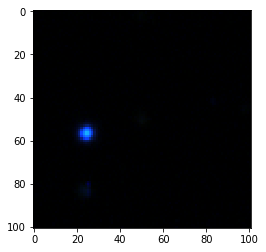

In [9]:
plt.imshow(ims[254].T)

In [10]:
ims = ims.ravel()

In [87]:
import copy
ims_copy = copy.copy(ims)

In [88]:
print 'max:',np.max(ims_copy)
print 'min:',np.min(ims_copy)
print 'mean:',np.mean(ims_copy)
print 'std:', np.std(ims_copy)

max: 102.838691711
min: -0.196141988039
mean: 0.0143963054095
std: 0.367250911369


In [89]:

ims_copy*=0.5
clip = 4

ims_copy = np.clip(ims_copy, -clip, clip)*25

print np.max(ims_copy)


100.0


max: 100.0
min: -2.45177485049
mean: 0.143490282203
std: 2.41791550747


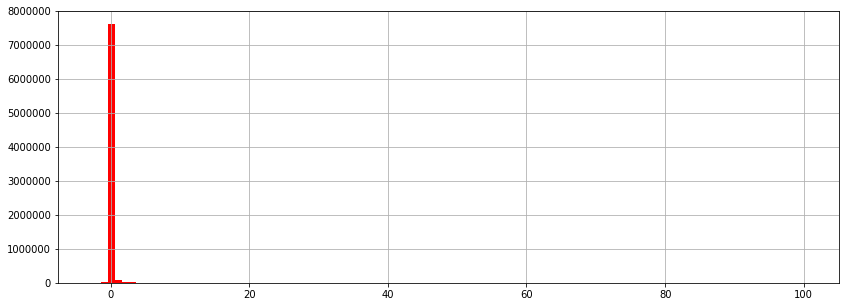

In [91]:
plt.figure(figsize= (14,5))
plt.hist(ims_copy, bins = 100, color = 'red', range = (np.min(ims_copy),np.max(ims_copy)))#, density = True)
# plt.xlim([90,100])
# plt.ylim([0,1000])
plt.grid(True)
print 'max:',np.max(ims_copy)
print 'min:',np.min(ims_copy)
print 'mean:',np.mean(ims_copy)
print 'std:', np.std(ims_copy)

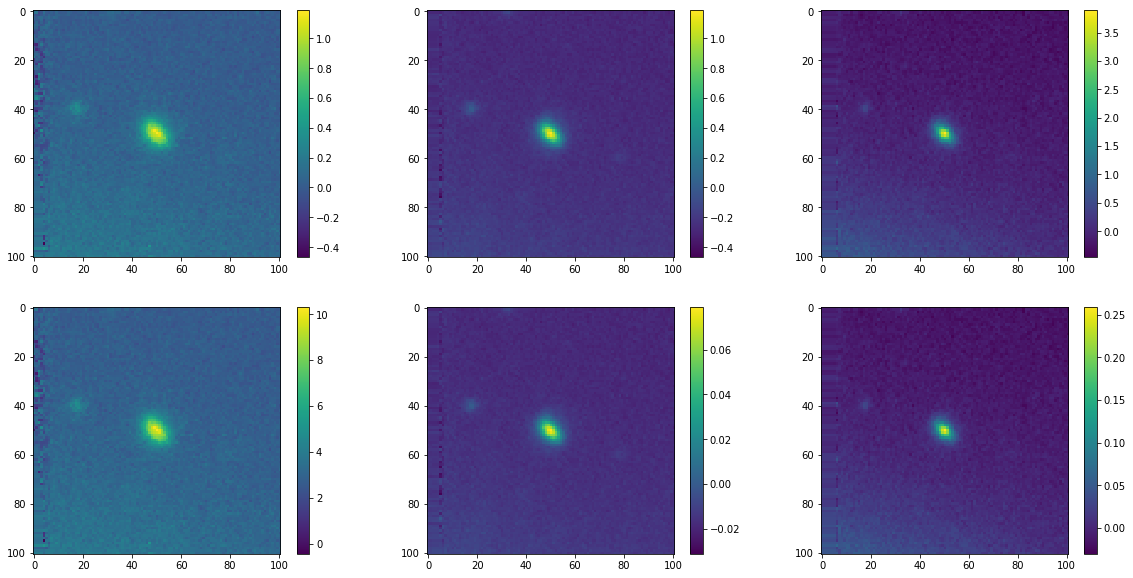

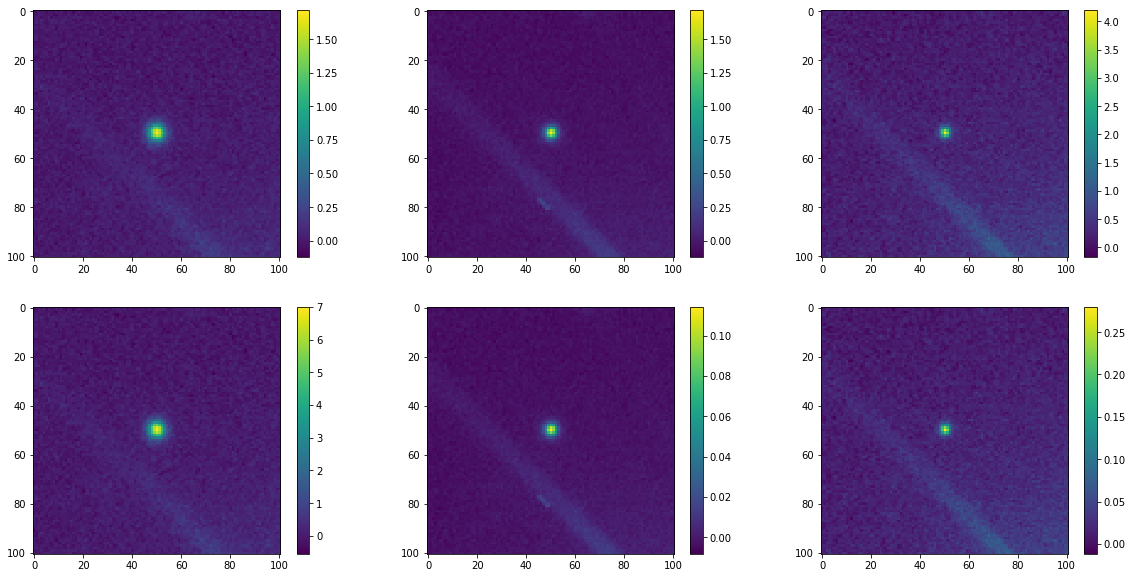

Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.


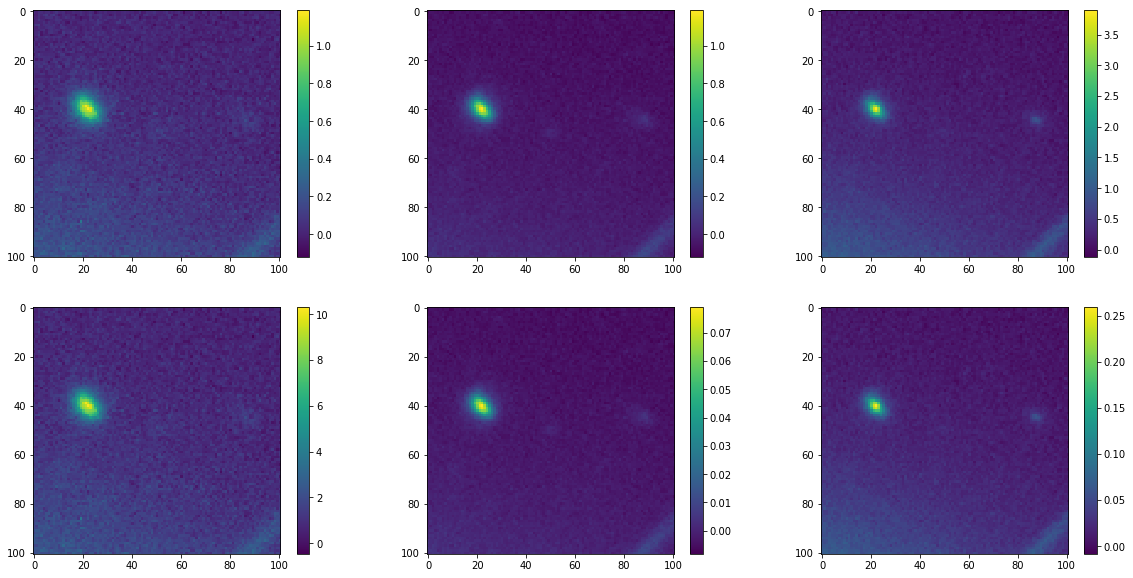

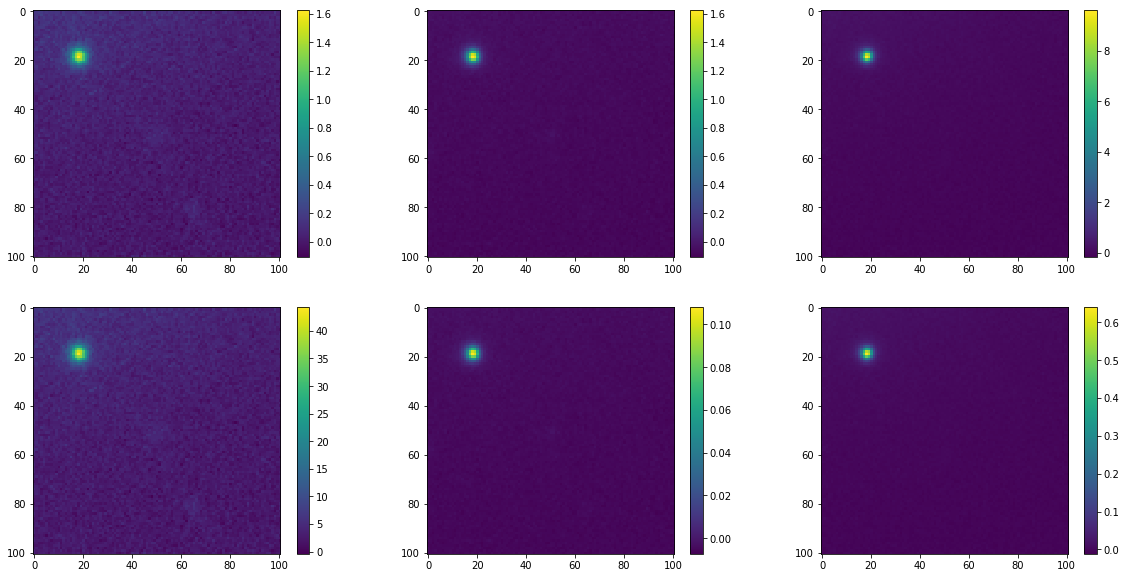

KeyboardInterrupt: 

In [77]:
for prep, image in zip(ims.reshape(-1,3,101,101)[88:98], ims_copy.reshape(-1,3,101,101)[88:98]):
    plt.figure(figsize = (20,10))
    plt.subplot(231)
    plt.imshow(image[0].T); plt.colorbar()
    plt.subplot(232)
    plt.colorbar()
    plt.imshow(image[1].T)
    plt.subplot(233)
    plt.colorbar()
    plt.imshow(image[2].T)
    plt.subplot(234)
    plt.colorbar()
    plt.imshow(prep[0].T)
    plt.subplot(235)
    plt.colorbar()
    plt.imshow(prep[1].T)
    plt.subplot(236)
    plt.colorbar()
    plt.imshow(prep[2].T)
    plt.show()

In [92]:
imgs = 240

download_path='//Volumes/CJSTORFER/' # To be adjusted on your machine

export_path=home+'/Desktop/'   # To be adjusted on your machine

d = Table.read(export_path+'catalogs_'+str(imgs)+'_RGB.hdf5', path='/ground')  

x = np.asarray(d['image']).reshape((-1,3,101,101))

In [93]:
x = x.ravel()

In [94]:
import copy
x_copy = copy.copy(x)

print 'max:',np.max(x_copy)
print 'min:',np.min(x_copy)
print 'mean:',np.mean(x_copy)
print 'std:', np.std(x_copy)

max: 100.0
min: -1.05758395097e-10
mean: 0.815810541453
std: 8.99530473667


In [95]:
vmin=-1e-9
vmax=1e-9
scale=100

mask = np.where(x == 100)


x_copy[mask] = 0

# Simple clipping and rescaling the images
x_copy = np.clip(x_copy, vmin, vmax)/vmax * scale

# x_copy-=np.mean(x_copy)

mask = np.where(x == 100)

x[mask] = 0


max: 100.0
min: -10.5758395097
mean: 0.23012201072
std: 2.28338524525


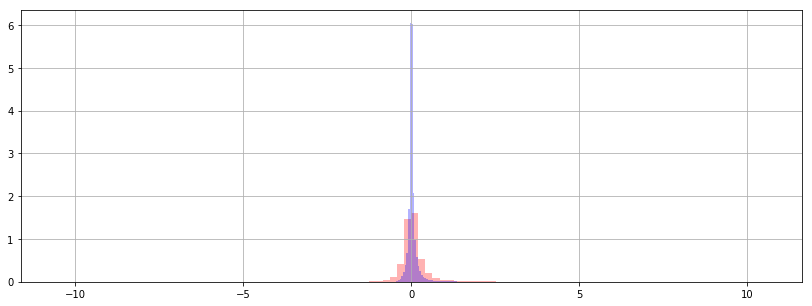

In [96]:
plt.figure(figsize= (14,5))
plt.hist(x_copy, bins = 100, color = 'red',alpha = 0.3, range = (x_copy.min(),-x_copy.min()),density = True)
plt.hist(ims_copy, bins = 100, color = 'blue',alpha = 0.3, range = (ims_copy.min(),-ims_copy.min()), density = True)
plt.grid(True)
print 'max:',np.max(x_copy)
print 'min:',np.min(x_copy)
print 'mean:',np.mean(x_copy)
print 'std:', np.std(x_copy)